In [3]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

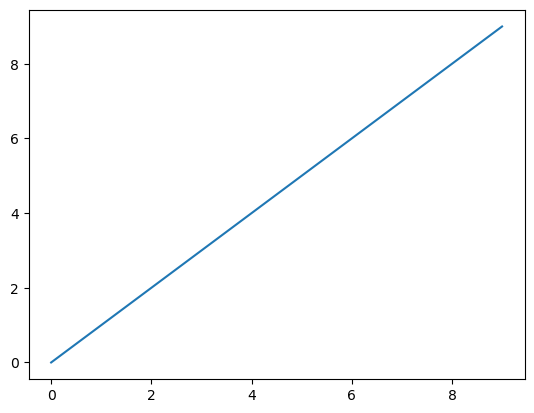

In [7]:
test = []
for i in range(10):
    test.append(i)
plt.plot(test)

In [13]:
transform = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])
batch_size = 20

df_train = datasets.ImageFolder("./train_another",transform=transform)
train_dataloader = DataLoader(dataset=df_train, batch_size=batch_size, shuffle=True)

df_test = datasets.ImageFolder("./test_another",transform=transform)
test_dataloader = DataLoader(dataset=df_test, batch_size=batch_size, shuffle=True)

df_validation = datasets.ImageFolder("./validation_another",transform=transform)
val_dataloader = DataLoader(dataset=df_validation, batch_size=batch_size, shuffle=True)

In [5]:
print('total training damage images: ',len(os.listdir("./train_another/damage")))
print('total validation damage images: ',len(os.listdir("./validation_another/damage")))
print('total test damage images: ',len(os.listdir("./test_another/damage")))
print('total training no damage images: ',len(os.listdir("./train_another/no_damage")))
print('total validation no damage images: ',len(os.listdir("./validation_another/no_damage")))
print('total test no damage images: ',len(os.listdir("./test_another/no_damage")))

total training damage images:  5000
total validation damage images:  1000
total test damage images:  8000
total training no damage images:  5000
total validation no damage images:  1000
total test no damage images:  1000


In [6]:
import torchvision

model = torchvision.models.vgg16(pretrained=True)
print(model)

c:\Users\spica\anaconda3\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\spica\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [8]:
num_classes = 1000

# Verrouillage des couches du modèle (sauf la dernière) pour éviter leur mise à jour lors de l'entraînement
for param in model.parameters():
    param.requires_grad = False

# Modification du nombre de classes en sortie (par défaut 1000) si nécessaire
model.classifier[6] = torch.nn.Linear(in_features=4096, out_features=num_classes)

# Déverrouillage de la dernière couche pour permettre son entraînement
for param in model.classifier[6].parameters():
    param.requires_grad = True

# Conversion en mode "entraînement"
model.train()

# Préparation des transformateurs pour les données d'entraînement
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

batch_size = 20
num_epochs = 10

trainset = torchvision.datasets.ImageFolder(root='./train_another', transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
loss_values = []

# Boucle d'entraînement
for epoch in range(num_epochs):
    for i, data in enumerate(trainloader, 0):
        # Chargement des entrées et des étiquettes
        inputs, labels = data
        
        # Calcul des sorties à l'aide de la méthode forward
        outputs = model(inputs)
        
        # Calcul de la perte
        criterion = torch.nn.CrossEntropyLoss()
        loss = criterion(outputs, labels)
        
        # Ajout de la perte à la liste
        loss_values.append(loss.item())
        # Calcul des gradients pour la rétropropagation
        optimizer = torch.optim.SGD(model.classifier[6].parameters(), lr=0.001, momentum=0.9)
        optimizer.zero_grad()
        loss.backward()
        
        # Mise à jour des paramètres du modèle
        optimizer.step()
        
        # Affichage de la progression de l'entraînement toutes les 100 itérations
        if i ==10:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, loss.item()))
            break

[1,    11] loss: 5.214
[2,    11] loss: 3.487
[3,    11] loss: 2.462
[4,    11] loss: 1.539
[5,    11] loss: 1.116
[6,    11] loss: 0.851
[7,    11] loss: 0.627
[8,    11] loss: 0.783
[9,    11] loss: 0.579
[10,    11] loss: 0.606


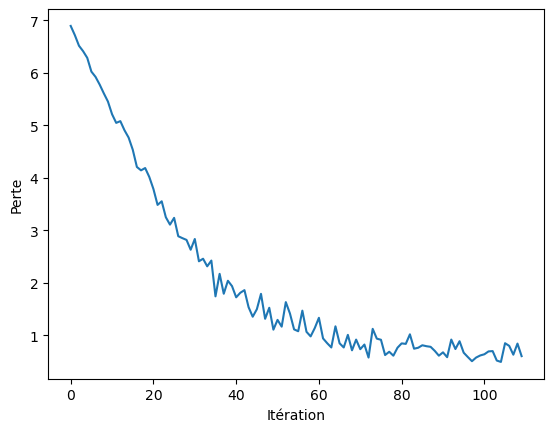

In [9]:
plt.plot(loss_values)
plt.xlabel('Itération')
plt.ylabel('Perte')
plt.show()

In [11]:
import torchsummary
torchsummary.summary(model, (3, 150, 150))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 150, 150]           1,792
              ReLU-2         [-1, 64, 150, 150]               0
            Conv2d-3         [-1, 64, 150, 150]          36,928
              ReLU-4         [-1, 64, 150, 150]               0
         MaxPool2d-5           [-1, 64, 75, 75]               0
            Conv2d-6          [-1, 128, 75, 75]          73,856
              ReLU-7          [-1, 128, 75, 75]               0
            Conv2d-8          [-1, 128, 75, 75]         147,584
              ReLU-9          [-1, 128, 75, 75]               0
        MaxPool2d-10          [-1, 128, 37, 37]               0
           Conv2d-11          [-1, 256, 37, 37]         295,168
             ReLU-12          [-1, 256, 37, 37]               0
           Conv2d-13          [-1, 256, 37, 37]         590,080
             ReLU-14          [-1, 256,